# 206_6.2_ランダム・佐々木方策と比較_upliftをKPI.ipynb

## 6.2 プラットフォーム全体で観測される報酬を最適化する方策学習

In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')
from matplotlib.lines import Line2D

from dataset import generate_synthetic_data2
# from policylearners import IPSBasedGradientPolicyLearner, CateBasedGradientPolicyLearner
from policylearners_sasaken_edit import IPSBasedGradientPolicyLearner, CateBasedGradientPolicyLearner_by_sk
from utils import softmax

import math
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import rankdata
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor

## ランダム方策と佐々木方策の関数定義を行う

### ランダム方策

In [2]:
def calc_random_pg(num_actions, test_data):
    q_x_a_1, q_x_a_0 = test_data["q_x_a_1"], test_data["q_x_a_0"]
    num_data = test_data['num_data']
    pi_random = np.full((num_data, num_actions), 1/num_actions)
    radom_pg = (pi_random * q_x_a_1 + (1 - pi_random) * q_x_a_0).sum(1).mean()
    return radom_pg

### 佐々木方策

In [3]:
def softmax(x):
# 各行に対してsoftmaxを適用
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # オーバーフロー防止
    return e_x / e_x.sum(axis=1, keepdims=True)

def calc_sasaken_pg(offline_logged_data, test_data):
    # データ整形: 観測される情報のみを持つDataFrameを生成する
    x = offline_logged_data['x']
    a_mat = offline_logged_data['a_mat']
    _q_x_a_0 = offline_logged_data['q_x_a_0'] # ノイズはないがログデータとして各コンテンツの試聴時間は得られているものとする
    _q_x_a_1 = offline_logged_data['q_x_a_1'] # ノイズはないがログデータとして各コンテンツの試聴時間は得られているものとする
    num_actions = _q_x_a_0.shape[1]
    # 結合
    combined = np.hstack([x, a_mat, _q_x_a_0, _q_x_a_1])
    # カラム名の生成
    columns = [f'x_{i}' for i in range(x.shape[1])] + [f'a_{i}' for i in range(a_mat.shape[1])]
    columns += [f'q_x_a_contents_{i}_not_recommended' for i in range(num_actions)]
    columns += [f'q_x_a_contents_{i}_recommended' for i in range(num_actions)]
    # DataFrame 作成
    df = pd.DataFrame(combined, columns=columns)

    # 初期化（NaNで埋める）
    for i in range(num_actions):
        df[f'observed_r_contents_{i}'] = np.nan
    
    # 各行でどのアクションが推薦されたか（a_i == 1の列）を使って代入
    for i in range(num_actions):
        recommended_mask = df[f'a_{i}'] == 1
        for j in range(num_actions):
            colname = f'observed_r_contents_{j}'
            source_col = (
                f'q_x_a_contents_{j}_recommended' if i == j
                else f'q_x_a_contents_{j}_not_recommended'
            )
            df.loc[recommended_mask, colname] = df.loc[recommended_mask, source_col]

    model_list = []
    for a_val in range(num_actions):
    
        # 説明変数: x0〜x4 + a（処置変数）
        feature_cols = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', f'a_{a_val}']
        X = df[feature_cols]
        y = df[f'observed_r_contents_{a_val}']  # 目的変数
        
        # 学習
        tmp_model = RandomForestRegressor(random_state=42)
        tmp_model.fit(X, y)
    
        model_list.append(tmp_model)

    # testデータをデータフレームに変換
    test_data_df = pd.DataFrame(test_data['x'], columns=[
        'x_0',
        'x_1',
        'x_2',
        'x_3',
        'x_4',
    ])
    
    for a_val in range(num_actions):
        # a_0
        ## a_0 not recommended
        tmp_test_data_df = test_data_df.copy()
        tmp_test_data_df[f'a_{a_val}'] = 0
        test_data_df[f'q_x_a_hat_contents_{a_val}_when_a_{a_val}_not_recommended'] = model_list[a_val].predict(
            tmp_test_data_df[['x_0', 'x_1', 'x_2', 'x_3', 'x_4', f'a_{a_val}']]
        )
        tmp_test_data_df = test_data_df.copy()
        
        ## a_0 recommended
        tmp_test_data_df[f'a_{a_val}'] = 1
        test_data_df[f'q_x_a_hat_contents_{a_val}_when_a_{a_val}_recommended'] = model_list[a_val].predict(
            tmp_test_data_df[['x_0', 'x_1', 'x_2', 'x_3', 'x_4', f'a_{a_val}']]
        )
    for a_val in range(num_actions):
        test_data_df[f'uplift_contents_{a_val}_by_recommend'] = test_data_df[f'q_x_a_hat_contents_{a_val}_when_a_{a_val}_recommended'] - test_data_df[f'q_x_a_hat_contents_{a_val}_when_a_{a_val}_not_recommended']

    # ソフトマックス適用
    q_hat = test_data_df[[f"uplift_contents_{a_val}_by_recommend" for a_val in range(num_actions)]].values
    pi_sasaken = softmax(q_hat)
    q_x_a_1, q_x_a_0 = test_data["q_x_a_1"], test_data["q_x_a_0"]
    sasaken_pg = (pi_sasaken * q_x_a_1 + (1 - pi_sasaken) * q_x_a_0).sum(1).mean()

    q_x_a_1_hat = np.array(test_data_df[[f"q_x_a_hat_contents_{a_val}_when_a_{a_val}_recommended" for a_val in range(num_actions)]])
    q_x_a_0_hat = np.array(test_data_df[[f"q_x_a_hat_contents_{a_val}_when_a_{a_val}_not_recommended" for a_val in range(num_actions)]])

    return sasaken_pg, q_x_a_1_hat, q_x_a_0_hat

### ログデータ(トレーニングデータ)のサイズ$n$を変化させたときの方策性能の変化

In [7]:
## シミュレーション設定
num_runs = 50 # シミュレーションの繰り返し回数

dim_x = 5 # 特徴量xの次元
num_actions = 10 # 行動数, |A|
beta = -0.1 # データ収集方策のパラメータ
max_iter = 21 # エポック数
test_data_size = 50000 # テストデータのサイズ
random_state = 12345
torch.manual_seed(random_state)
random_ = check_random_state(random_state)

num_actions_list = [2, 10] # 行動数

num_data_list = [100, 500, 1000, 2000] # トレーニングデータのサイズ

In [8]:
result_df_data_list = []
for num_actions in num_actions_list:
    ## 期待報酬関数を定義するためのパラメータを抽出
    theta_1 = random_.normal(size=(dim_x, num_actions))
    M_1 = random_.normal(size=(dim_x, num_actions))
    b_1 = random_.normal(size=(1, num_actions))
    theta_0 = random_.normal(size=(dim_x, num_actions))
    M_0 = random_.normal(size=(dim_x, num_actions))
    b_0 = random_.normal(size=(1, num_actions))
    ## 学習された方策の真の性能を近似するためのテストデータを生成
    test_data = generate_synthetic_data2(
        num_data=test_data_size, beta=beta,
        theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
        dim_context=dim_x, num_actions=num_actions, random_state = random_state
    )
    pi_0, q_x_a_1, q_x_a_0 = test_data["pi_0"], test_data["q_x_a_1"], test_data["q_x_a_0"]
    pi_0_value = (pi_0 * q_x_a_1 + (1. - pi_0) * q_x_a_0).sum(1).mean()

    result_df_list = []
    for num_data in num_data_list:
        test_policy_value_list = []
        for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
            ## データ収集方策が形成する分布に従いログデータを生成
            offline_logged_data = generate_synthetic_data2(
                num_data=num_data, beta=beta,
                theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
                dim_context=dim_x, num_actions=num_actions, random_state = _
            )

            true_value_of_learned_policies = dict()
            true_value_of_learned_policies["logging"] = pi_0_value

            ## ログデータを用いてオフ方策学習を実行する
            ### 勾配ベースのアプローチ (IPS推定量で方策勾配を推定)
            ips = IPSBasedGradientPolicyLearner(
                dim_x=dim_x, num_actions=num_actions, max_iter=max_iter, random_state=random_state + _
            )
            ips.fit(offline_logged_data, test_data)
            pi_ips = ips.predict(test_data)
            true_value_of_learned_policies["ips-pg"] = (pi_ips * q_x_a_1 + (1 - pi_ips) * q_x_a_0).sum(1).mean()

            sasaken_pg, q_x_a_1_hat, q_x_a_0_hat = calc_sasaken_pg(offline_logged_data=offline_logged_data, test_data=test_data)
            ### 勾配ベースのアプローチ (新たに開発した推定量で方策勾配を推定)
            cate = CateBasedGradientPolicyLearner_by_sk(
                dim_x=dim_x, num_actions=num_actions, max_iter=max_iter, random_state=random_state + _
            )
            cate.fit(offline_logged_data, test_data,
                q_x_a_1_hat,
                q_x_a_0_hat
            )
            pi_cate = cate.predict(test_data)
            true_value_of_learned_policies["cate-pg"] = (pi_cate * q_x_a_1 + (1 - pi_cate) * q_x_a_0).sum(1).mean()
            
            ### ランダム
            true_value_of_learned_policies["random-pg"] = calc_random_pg(num_actions=num_actions, test_data=test_data)

            ### 佐々木オリジナル
            true_value_of_learned_policies["sasaken-pg"] = sasaken_pg

            
            test_policy_value_list.append(true_value_of_learned_policies)
            
        ## シミュレーション結果の集計
        result_df = DataFrame(test_policy_value_list).stack().reset_index(1)\
            .rename(columns={"level_1": "method", 0: "value"})
        result_df["num_data"] = num_data
        result_df["pi_0_value"] = pi_0_value
        result_df["rel_value"] = result_df["value"] / pi_0_value
        result_df_list.append(result_df)
    result_df_data_list.append(pd.concat(result_df_list).reset_index(level=0))

num_data=2000...: 100%|█████████████████████████████████████████████████████████████████| 50/50 [11:28<00:00, 13.78s/it]


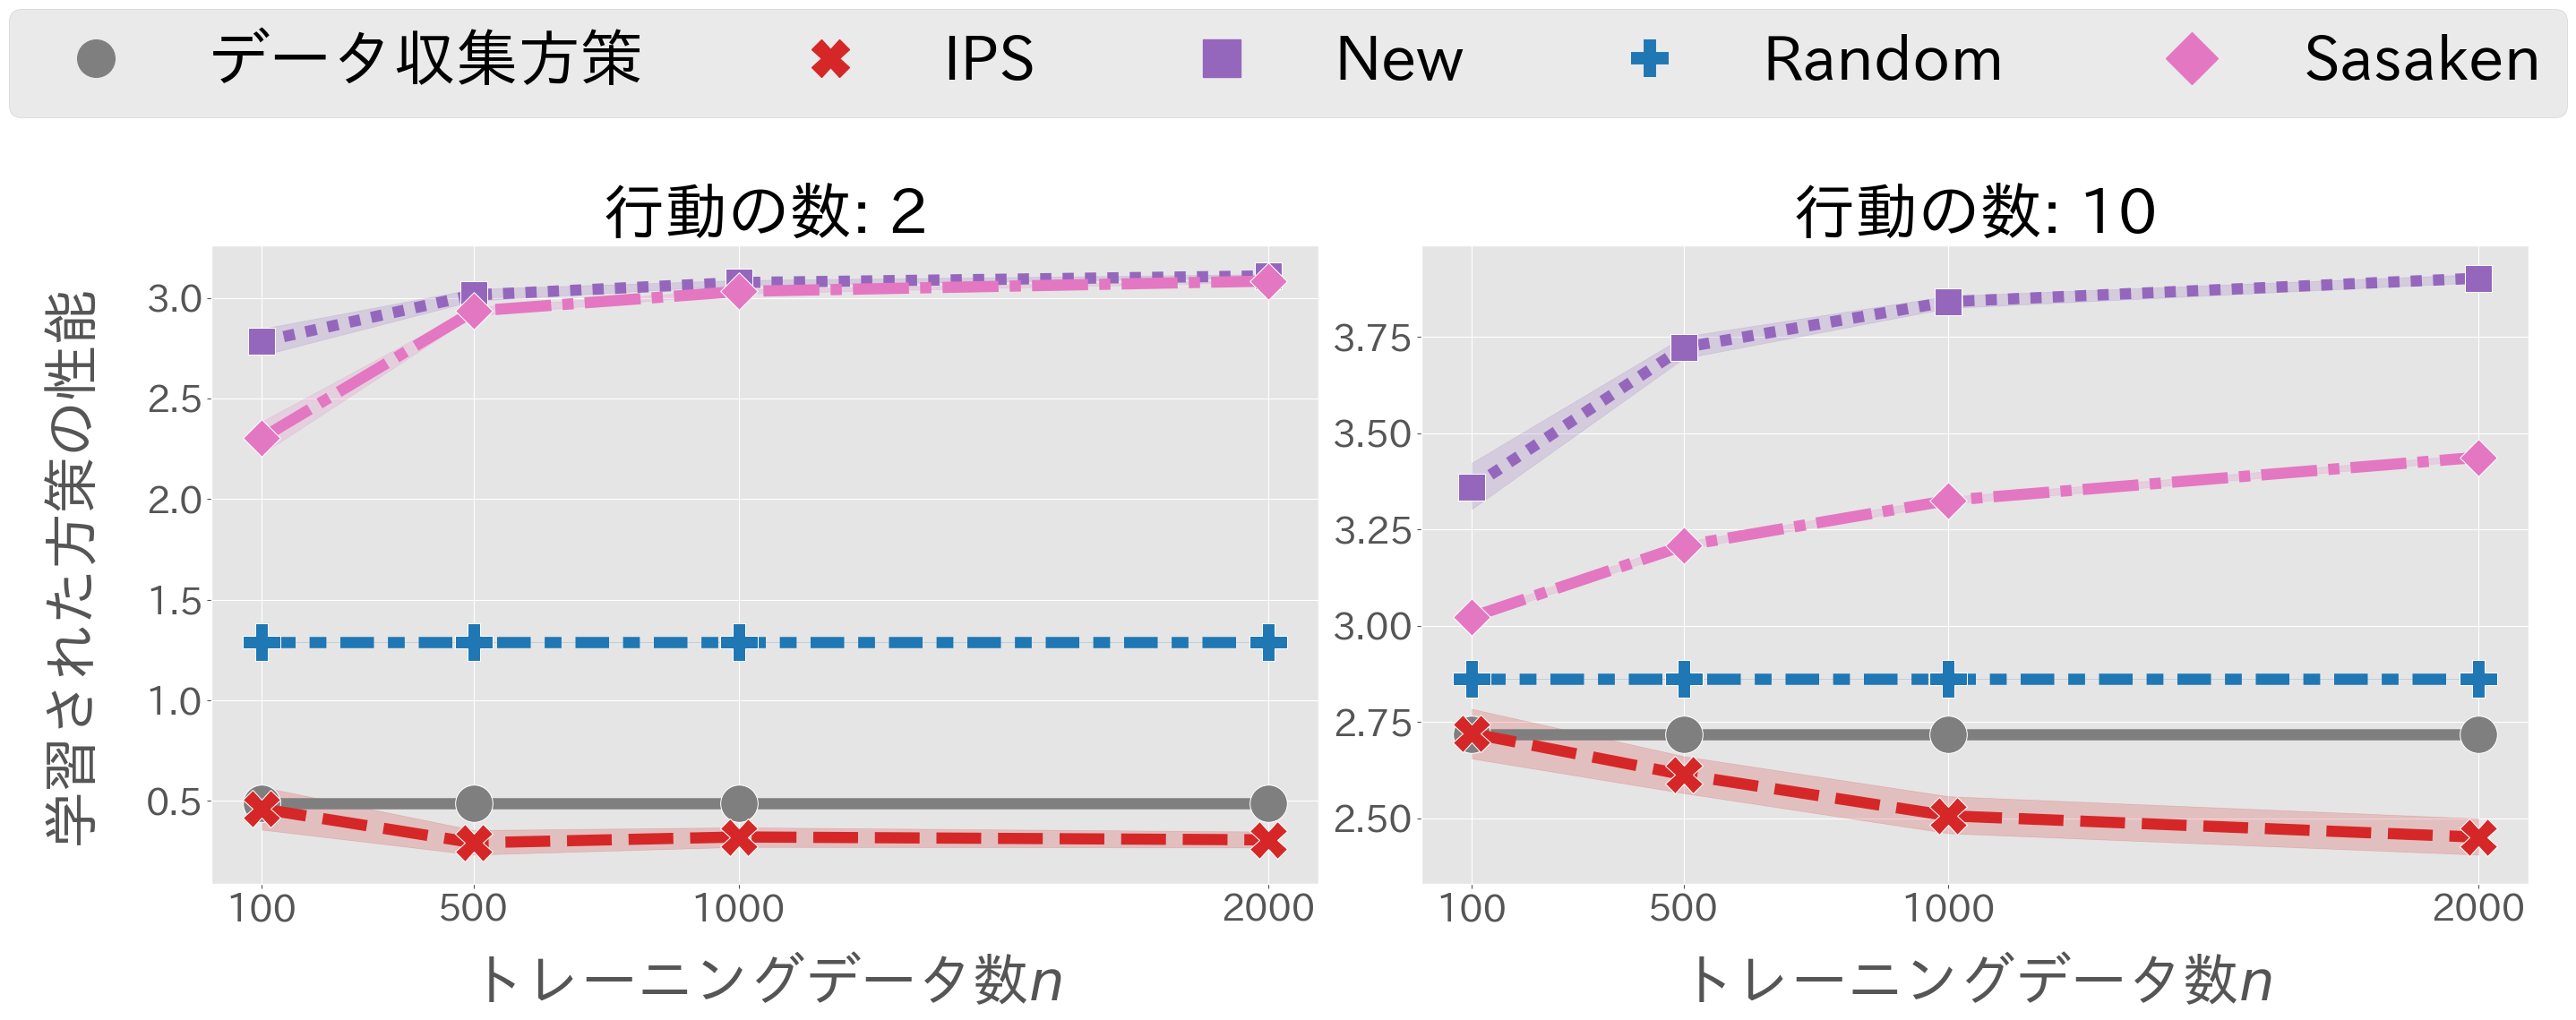

In [9]:
fig, ax_list = plt.subplots(1, len(num_actions_list), figsize=(28, 9.5), tight_layout=True)
for i, (num_actions, result_df) in enumerate(zip(num_actions_list, result_df_data_list)):
    ax = ax_list[i]
    sns.lineplot(
        linewidth=9,
        markersize=30,
        markers=True,
        x="num_data",
        y="value",
        hue="method",
        style="method",
        ax=ax,
        palette=["tab:grey", "tab:red", "tab:purple", "tab:blue", "tab:pink"],
        legend=False,
        data=result_df,
    )
    ax.set_title(f"行動の数: {num_actions}", fontsize=50)
    # yaxis
    if i == 0:
        ax.set_ylabel("学習された方策の性能", fontsize=45)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xlabel("トレーニングデータ数$n$", fontsize=45)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.11)
# fig.legend(["データ収集方策", "IPS", "New"], fontsize=50, bbox_to_anchor=(0.5, 1.13), ncol=5, loc="center")

custom_lines = [
    Line2D([0], [0], color="tab:grey", marker='o', markersize=30, linestyle='None', label="データ収集方策"),
    Line2D([0], [0], color="tab:red", marker='X', markersize=30, linestyle='None', label="IPS"),
    Line2D([0], [0], color="tab:purple", marker='s', markersize=30, linestyle='None', label="New"),
    Line2D([0], [0], color="tab:blue", marker='+', markersize=30, markeredgewidth=10, linestyle='None', label="Random"),
    Line2D([0], [0], color="tab:pink", marker='D', markersize=30, linestyle='None', label="Sasaken"),
]

fig.legend(
    handles=custom_lines,
    fontsize=50,
    bbox_to_anchor=(0.5, 1.13),
    ncol=5,
    loc="center"
)